# EDA (Basics & FFT)

In [1]:
import math
import datetime
import numpy as np
import pandas as pd

import scipy.fftpack

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
sns.set(style="whitegrid")

## Load the data

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# cd 'gdrive/My Drive/Colab Notebooks/aiforsea'

In [4]:
df = pd.read_csv('full_data.csv')
df.head()

,geohash6,day,demand,in_raw,weekday,hour,minutes,ds,latitude,longitude
0,qp09du,1,0.000000,False,1,0,0,1900-01-01 00:00:00,-5.336609,90.829468
1,qp09jm,1,0.000000,False,1,0,0,1900-01-01 00:00:00,-5.419006,90.939331
2,qp09sf,1,0.000000,False,1,0,0,1900-01-01 00:00:00,-5.347595,90.917358
3,qp09vd,1,0.000000,False,1,0,0,1900-01-01 00:00:00,-5.303650,90.950317
4,qp03y4,1,0.002732,True,1,0,0,1900-01-01 00:00:00,-5.303650,90.620728


## Plots

### Demand per weekday and hour heatmap

Text(0.5, 1, 'Demand per weekday and hour heatmap')

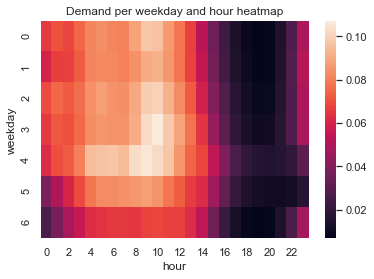

In [5]:
piv = pd.pivot_table(df, values="demand", index=["weekday"], columns=["hour"], fill_value=0)

sns.heatmap(piv)
plt.title("Demand per weekday and hour heatmap")

### Demand by location

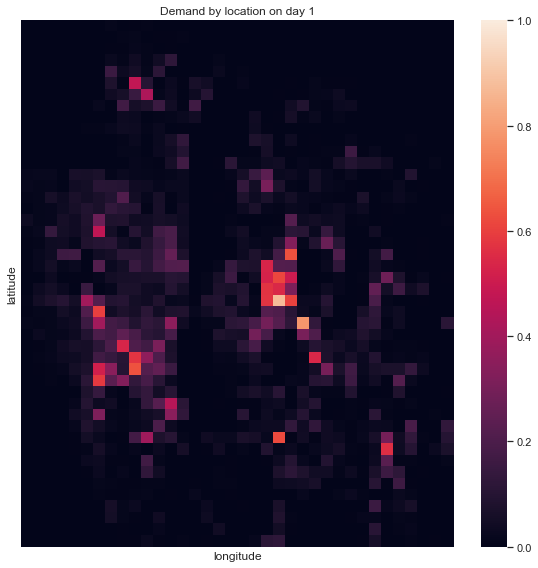

In [6]:
DAY = 1

piv = pd.pivot_table(df[df['day'] == DAY], values="demand",
                     index=["latitude"], columns=["longitude"], fill_value=0)

plt.clf
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
sns.heatmap(piv, vmin=0.0, vmax=1.0, ax=ax)

plt.title("Demand by location on day {}".format(DAY))
plt.xticks([])
plt.yticks([])

plt.tight_layout()
# plt.savefig('demand_dist/day{}'.format(day))
plt.show()

In [7]:
# for day in range(1, 61+1):
#     piv = pd.pivot_table(df[df['day'] == day], values="demand",
#                          index=["lat"], columns=["long"], fill_value=0)
# 
#     fig = plt.figure(figsize=(8, 8))
#     sns.heatmap(piv, vmin=0.0, vmax=1.0)
# 
#     plt.tight_layout()
#     plt.savefig('demand_dist/day{}'.format(day))
#     plt.show()

### Mean demand over time

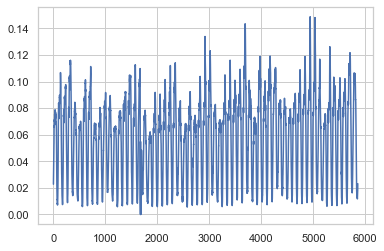

In [8]:
mean_demand = df.groupby('ds')['demand'].mean().reset_index()
plt.plot(mean_demand['demand'])

### Demand distribution

(array([6515240.,  692727.,  256063.,  114699.,   60155.,   35849.,
          24362.,   17431.,   13309.,   52789.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

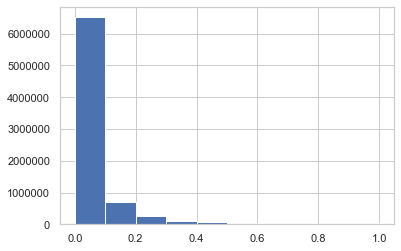

In [9]:
plt.hist(df['demand'])

(array([3.576304e+06, 5.000000e+00, 2.100000e+01, 2.620000e+02,
        1.788000e+03, 1.427700e+04, 1.141870e+05, 7.881840e+05,
        2.280366e+06, 1.007230e+06]),
 array([-2.07232658e+01, -1.86509393e+01, -1.65786127e+01, -1.45062861e+01,
        -1.24339595e+01, -1.03616329e+01, -8.28930633e+00, -6.21697975e+00,
        -4.14465317e+00, -2.07232658e+00,  1.00000008e-09]),
 <a list of 10 Patch objects>)

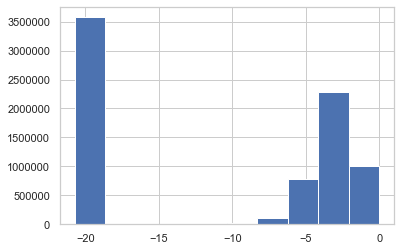

In [10]:
plt.hist(np.log(df['demand'].values + 1e-9))

(array([2.000000e+00, 8.000000e+00, 7.600000e+01, 5.500000e+02,
        3.502000e+03, 2.481100e+04, 1.703300e+05, 9.553760e+05,
        2.190426e+06, 8.612400e+05]),
 array([-1.93141789e+01, -1.73827610e+01, -1.54513431e+01, -1.35199252e+01,
        -1.15885073e+01, -9.65708945e+00, -7.72567156e+00, -5.79425367e+00,
        -3.86283578e+00, -1.93141789e+00,  1.00000008e-09]),
 <a list of 10 Patch objects>)

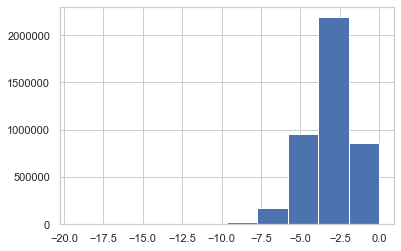

In [11]:
plt.hist(np.log(df[df['in_raw']]['demand'].values + 1e-9))

## Fourier Transform

In [12]:
df_fft = df.groupby(['ds'])["demand"].mean().reset_index()
df_fft.head()

,ds,demand
0,1900-01-01 00:00:00,0.022744
1,1900-01-01 00:15:00,0.025120
2,1900-01-01 00:30:00,0.027232
3,1900-01-01 00:45:00,0.029258
4,1900-01-01 01:00:00,0.033303


### Center around 0

In [13]:
demand_mean = df_fft['demand'].mean()
df_fft['demand'] -= demand_mean
print("Mean demand:", demand_mean)

Mean demand: 0.0567989922757905


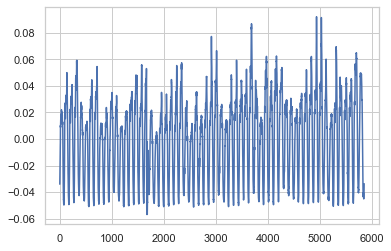

In [14]:
plt.plot(df_fft['demand'])

### Do FFT

In [15]:
%%time
yf = scipy.fftpack.fft(df_fft['demand'].values)
xf = scipy.fftpack.fftfreq(yf.size, 1 / (4*24))

Wall time: 9 ms


Text(0.5, 0, 'Frequency (1/day)')

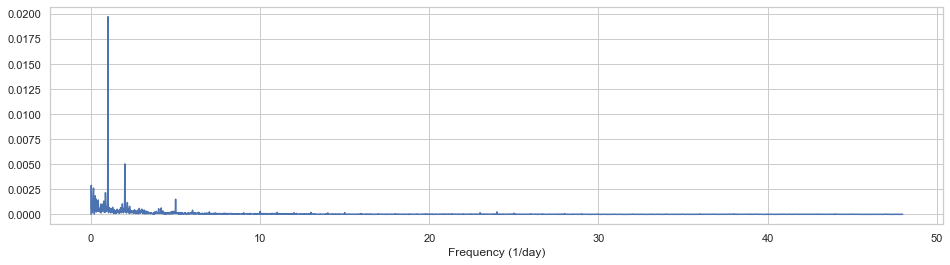

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(xf[:xf.size//2], 1.0/yf.size * abs(yf)[:yf.size//2])
ax.set_xlabel('Frequency (1/day)')

### Reconstruct

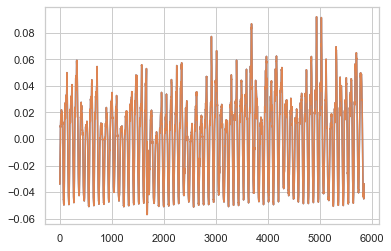

In [17]:
demand_recon = np.real(scipy.fftpack.ifft(yf))
plt.plot(df_fft['demand'])
plt.plot(demand_recon)

### Reconstruct using integer frequencies

In [18]:
eps = 0.1
freqs = [1, 2]

yf_recon = np.zeros(yf.size,dtype=np.complex_)
for i in freqs:
    cur_range = (i-eps < np.abs(xf)) & (np.abs(xf) < i+eps)
    yf_recon[cur_range] = yf[cur_range]

(0, 10)

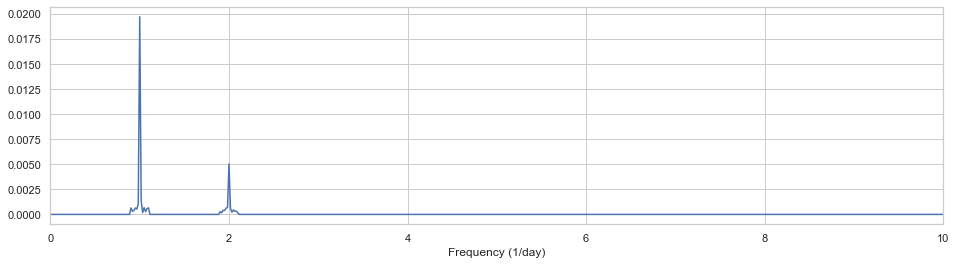

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(xf[:xf.size//2], 1.0/yf_recon.size * abs(yf_recon)[:yf_recon.size//2])
ax.set_xlabel('Frequency (1/day)')
ax.set_xlim(0, 10)

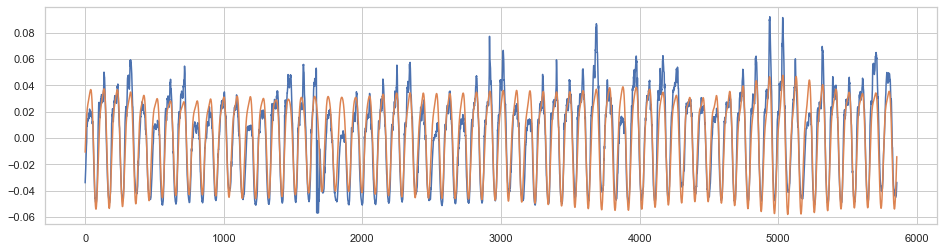

In [20]:
demand_recon = np.real(scipy.fftpack.ifft(yf_recon))
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(df_fft['demand'])
plt.plot(demand_recon)

### Reconstruct using frequencies from 1-2 Hz

In [21]:
%%time
eps = 0.1
till_freq = 2

yf_recon = np.zeros(yf.size,dtype=np.complex_)
yf_recon[np.abs(xf) <= till_freq + eps] = yf[np.abs(xf) <= till_freq + eps]

Wall time: 0 ns


(0, 5)

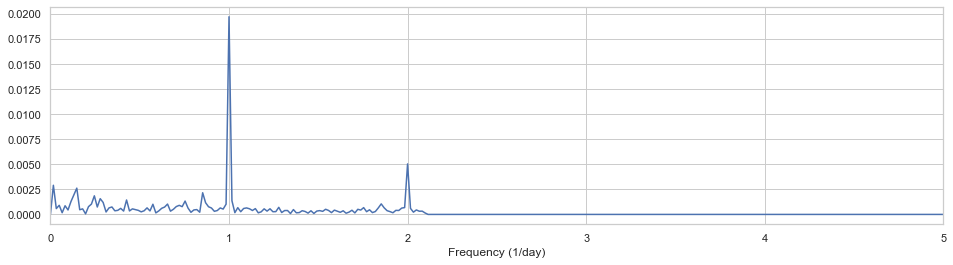

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(xf[:xf.size//2], 1.0/yf_recon.size * abs(yf_recon)[:yf_recon.size//2])
ax.set_xlabel('Frequency (1/day)')
ax.set_xlim(0, 5)

In [23]:
%%time
demand_recon = np.real(scipy.fftpack.ifft(yf_recon))

Wall time: 0 ns


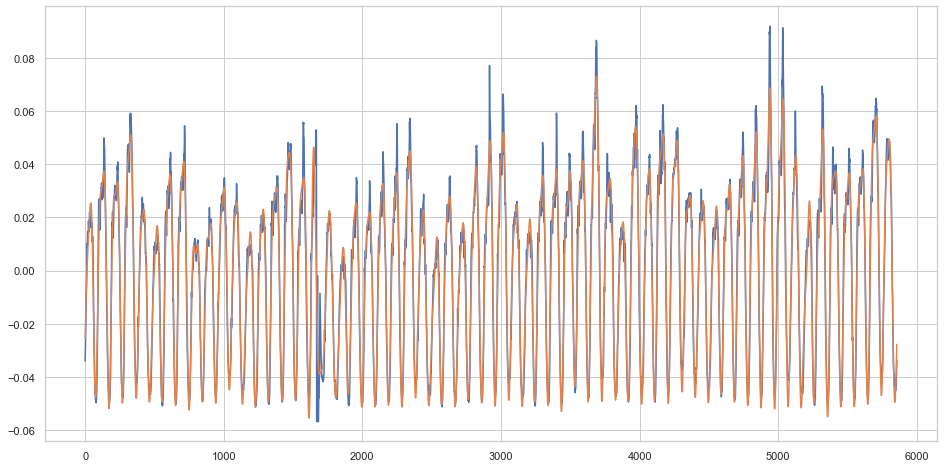

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
plt.plot(df_fft['demand'])
plt.plot(demand_recon)